In [85]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
from glob import glob
import tensorflow as tf
import os
from sklearn.model_selection import train_test_split, KFold
# save the final model to file
from keras.datasets import mnist
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.optimizers import SGD
import imutils
# from keras.models import load_mode
def imshow(img):
    
    plt.figure(figsize=(6,6))
    plt.axis('off')
    plt.imshow(img, cmap='gray')
    plt.show()

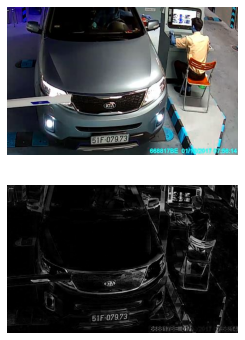

In [86]:
origin=cv2.imread("data/car_long/261.jpg")
gray=cv2.cvtColor(origin, cv2.COLOR_RGB2GRAY)
plt.figure(figsize=(6,6))
plt.subplot(211)
plt.axis('off')
plt.imshow(origin)

# gray=cv2.imread("data/car_long/128.jpg", 0)
rectKern = cv2.getStructuringElement(cv2.MORPH_RECT, (13, 5))
blackhat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, rectKern)
plt.subplot(212)
plt.axis('off')
plt.imshow(blackhat, cmap='gray')
plt.show()
# imshow(blackhat)

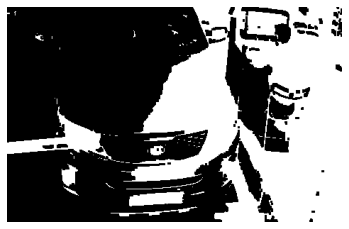

In [87]:
squareKern = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
light = cv2.morphologyEx(gray, cv2.MORPH_CLOSE, squareKern)
light = cv2.threshold(light, 0, 255,cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
imshow(light)


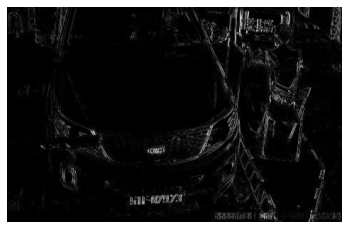

In [88]:
gradX = cv2.Sobel(blackhat, ddepth=cv2.CV_32F,dx=1, dy=0, ksize=-1)
gradX = np.absolute(gradX)
(minVal, maxVal) = (np.min(gradX), np.max(gradX))
gradX = 255 * ((gradX - minVal) / (maxVal - minVal))
gradX = gradX.astype("uint8")
imshow(gradX)

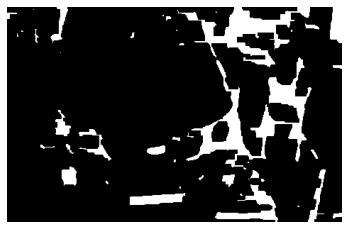

In [89]:
gradX = cv2.GaussianBlur(gradX, (5, 5), 0)
gradX = cv2.morphologyEx(gradX, cv2.MORPH_CLOSE, rectKern)
thresh = cv2.threshold(gradX, 0, 255,cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
imshow(thresh)

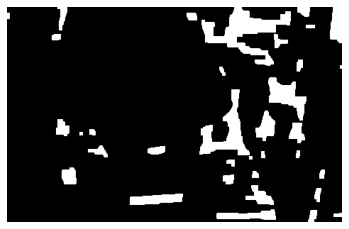

In [90]:
thresh = cv2.erode(thresh, None, iterations=2)
thresh = cv2.dilate(thresh, None, iterations=2)
imshow(thresh)

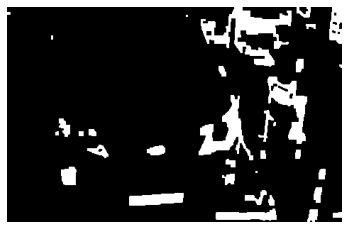

In [91]:
thresh = cv2.bitwise_and(thresh, thresh, mask=light)
thresh = cv2.dilate(thresh, None, iterations=2)
thresh = cv2.erode(thresh, None, iterations=1)
imshow(thresh)

In [92]:
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
cnts = sorted(cnts, key=cv2.contourArea, reverse=True)[:5]

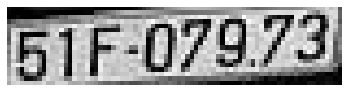

In [93]:
lpCnt = None
roi = None
# loop over the license plate candidate contours
for c in cnts:
    # compute the bounding box of the contour and then use
    # the bounding box to derive the aspect ratio
    (x, y, w, h) = cv2.boundingRect(c)
    ar = w / float(h)
    if ar >= 2 and ar < 5:
        # store the license plate contour and extract the
        # license plate from the grayscale image and then
        # threshold it
        lpCnt = c
        licensePlate = gray[y:y + h, x:x + w]
        roi = cv2.threshold(licensePlate, 0, 255,
            cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
        imshow(licensePlate)